# Homework 7 Template

Rixin Li & G . Besla



In [1]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [138]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
import CenterOfMass2 as COM


# **** import the GalaxyMass to determine the mass of M31 for each component
import GalaxyMass as GM

# M33AnalyticOrbit

In [139]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self,filename): # **** add inputs
        """ initialize the parameters of the M33 orbit around M31 
        input: filename - the name of the output file to store the orbit data
                """
        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.fileout = filename
        M33_file = "/Users/swapnaneeldey/Desktop/ASTR400Bfiles/M33/M33_000.txt"
        M31_file = "/Users/swapnaneeldey/Desktop/ASTR400Bfiles/M31/M31_000.txt"
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        M33COM = COM.CenterOfMass(M33_file,2)

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        self.PM33 = M33COM.COM_P(0.1,4).value


        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        self.VM33 = M33COM.COM_V(self.PM33[0]*u.kpc,self.PM33[1]*u.kpc, self.PM33[2]*u.kpc).value

        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31COM = COM.CenterOfMass(M31_file,2)

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        self.PM31 = M31COM.COM_P(0.1,2).value

        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        self.VM31 = M31COM.COM_V(self.PM31[0]*u.kpc,self.PM31[1]*u.kpc, self.PM31[2]*u.kpc).value
        
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r = self.PM33 - self.PM31 
        self.v = self.VM33 - self.VM31
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = GM.ComponentMass(M31_file, 2) * 1e12 
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = GM.ComponentMass(M31_file,  3) * 1e12 
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 60
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = GM.ComponentMass(M31_file, 1) * 1e12 
    
    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """ calculates the Halo and Buldge acceleration using the Hernquist profile
        input: M - mass of the component (bulge or halo)
               r_a - scale length of the component (bulge or halo)
               r - position vector (default is self.r)
               
        output: Hern - acceleration vector of the component (bulge or halo)"""
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(np.sum(r**2)) 
        
        ### *** Store the Acceleration
        Hern = -(self.G*M)*r/(rmag*(r_a + rmag)**2)  #follow the formula in the HW instructions
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):# it is easiest if you take as an input a position VECTOR  r 
        """ Calculates the Disk acceleration using the Miyamoto-Nagai 1975 profile
            input: M - mass of the disk
            r_d - scale length of the disk  (default is self.rdisk)
            r - position vector (default is self.r)"""

        
        ### Acceleration **** follow the formula in the HW instructions
        R = np.sqrt(r[0]**2 + r[1]**2)
        z_d = r_d/5.0
        B = r_d + np.sqrt(r[2]**2 + z_d**2)
        MNa = -(self.G*M)*r/(R**2 + B**2)**(3/2) * np.array([1, 1, B/np.sqrt(r[2]**2 + z_d**2)])
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        return MNa
       
        return 
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """Function to sum all acceleration vectors from each galaxy component
        input- r - x,y,z, the 3D position vector (default is self.r)
        output- a 3D acceleration vector for M31"""

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        Halo_acc = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        Bulge_acc = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        Disk_acc = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        #summing the three vectors
        total_acc = np.sum([Halo_acc, Bulge_acc, Disk_acc], axis=0)
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return total_acc
    
    
    
    def LeapFrog(self, dt, r , v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ Function that establishes the leap frog method.
         Input - dt - the time step
                 r - position vector (default is self.r)
                 v - velocity vector (default is self.v)
         Output - rnew - the new position vector after dt
                 vnew - the new velocity vector after dt"""
        
        # predict the position at the next half timestep
        rhalf = r + v*dt/2
        # calling acceleration from M31Accel
        a = self.M31Accel(rhalf)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + a*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + (vnew)*dt/2
        
        return rnew, vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ Function which loops over LeapFrog integratort to solve the eequation of motions and compute the future orbit
         of M33 for 10 Gyr into the future.
         
         Input - t0 - starting time (in Gyr)
                dt - timestep (in Gyr)
                tmax - final time (in Gyr)
         Output - A file with the orbit data for M33, including time, position and velocity vectors
        """

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r), *tuple(self.v)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax):  # as long as t has not exceeded the maximal time 
            # **** advance the time by one timestep, dt
            t = t + dt
            # **** store the new time in the first column of the ith row
            orbit[i,0] = t
            r_old = orbit[i-1, 1:4] # store the previous position vector
            v_old = orbit[i-1, 4:7] # store the previous velocity vector
            # ***** advance the position and velocity using the LeapFrog scheme
            rnew, vnew = self.LeapFrog(dt, r_old, v_old)
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
      
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 1:4] = rnew[0], rnew[1], rnew[2]
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
               
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 4:7] = vnew[0], vnew[1], vnew[2]
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
        
        print(self.fileout)
        # write the data to a file
        np.savetxt("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/Homeworks/Homework7/"+self.fileout, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        
        

In [140]:
M33_orbit = M33AnalyticOrbit("M33_predicted_orbit.txt")

In [141]:
M33_orbit.OrbitIntegration(0, 0.1, 10)

M33_predicted_orbit.txt


In [142]:
M33_pred_orbit = np.genfromtxt("M33_predicted_orbit.txt", comments='#', names=True)

In [143]:
mag_pos = np.sqrt(M33_pred_orbit['x']**2 + M33_pred_orbit['y']**2 + M33_pred_orbit['z']**2)
mag_vel = np.sqrt(M33_pred_orbit['vx']**2 + M33_pred_orbit['vy']**2 + M33_pred_orbit['vz']**2)

In [144]:
M31 = np.genfromtxt("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/Homeworks/Homework6/Orbit_M31.txt", comments='#', names=True)
M33 = np.genfromtxt("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/Homeworks/Homework6/Orbit_M33.txt", comments='#', names=True)

In [145]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def relative_mag(galaxy_1, galaxy_2):
    """Calculate the relative position and relative velocity of the galaxies
    
    Inputs:
    galaxy_1: the name of the first galaxy
    galaxy_2: the name of the second galaxy     
    
    Returns:
    relative_position: the relative position of the two galaxies
    relative_velocity: the relative velocity of the two galaxies
    """
    # Calculate the relative position and relative velocity of the two galaxies
    relative_position = np.sqrt((galaxy_1["x"] - galaxy_2["x"])**2 + (galaxy_1["y"] - galaxy_2["y"])**2 + (galaxy_1["z"] - galaxy_2["z"])**2)
    relative_velocity = np.sqrt((galaxy_1["vx"] - galaxy_2["vx"])**2 + (galaxy_1["vy"] - galaxy_2["vy"])**2 + (galaxy_1["vz"] - galaxy_2["vz"])**2)

    return relative_position, relative_velocity

    
# of M33 and M31
rel_pos_M33_M31, rel_vel_M33_M31 = relative_mag(M33, M31)

In [146]:
plt.rcParams.update({
    "font.family": "DejaVu Serif",   # specify font family here
    "font.serif": ["cm"],
    "mathtext.fontset" : "dejavuserif" ,
    "font.size":17,
    "axes.titlesize" : 20,
    "axes.labelsize" : 20,
    "axes.linewidth" : 1.5,
    "lines.linewidth" : 2.0,
    "xtick.labelsize" :15,
    "ytick.labelsize" : 15,
    "xtick.major.size" : 15,
    "xtick.minor.size" : 0,
    "ytick.major.size" : 15,
    "ytick.minor.size" : 0,
    "xtick.major.width" : 2,
    "xtick.minor.width" : 2,
    "ytick.major.width" : 2,
    "ytick.minor.width" : 2})  
plt.rcParams["legend.frameon"] = True


Text(0, 0.5, 'Relative Position (kpc)')

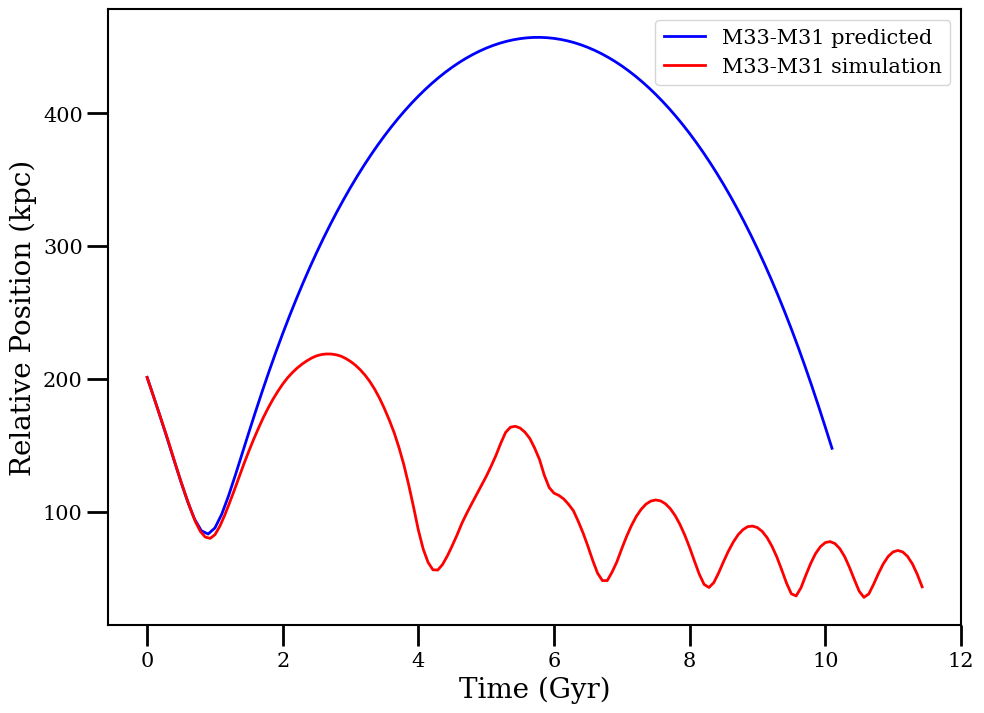

In [149]:
#plotting relative position

fig= plt.figure(figsize=(11,8))
plt.plot(M33_pred_orbit['t'], mag_pos, label = 'M33-M31 predicted', color = 'blue')
plt.plot(M31["t"], rel_pos_M33_M31, label='M33-M31 simulation', color='r')
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('Time (Gyr)', fontsize=20)
plt.ylabel('Relative Position (kpc)', fontsize=20)

Text(0, 0.5, 'Relative velocity (km/s)')

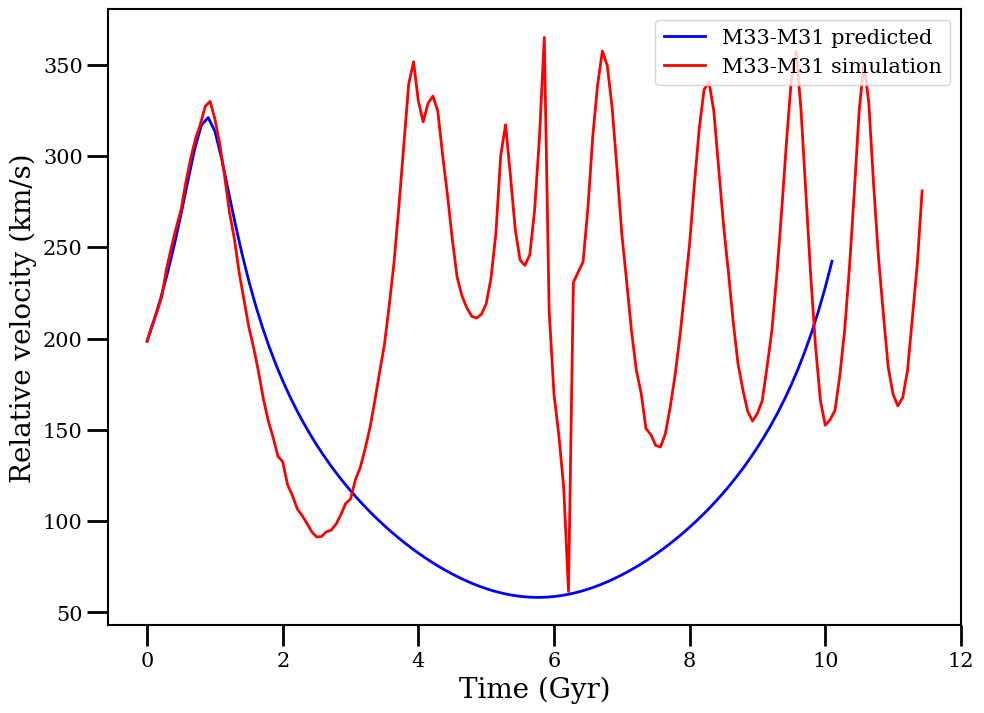

In [150]:
#plotting relative velocities
fig= plt.figure(figsize=(11,8))
plt.plot(M33_pred_orbit['t'], mag_vel, label = 'M33-M31 predicted', color = 'blue')
plt.plot(M31["t"], rel_vel_M33_M31, label='M33-M31 simulation', color='r')
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('Time (Gyr)', fontsize=20)
plt.ylabel('Relative velocity (km/s)', fontsize=20)

2) The plots dont compare that well for except the first 2 Gyr. After that our analytical solution seems to be quite extreme in both velocity and positon. The two also start ending at the same time as the simulated data is starting to converge to the equilibrium state.

3) With each iteration the code seems to be taking the COM of both the system wrong. Some of the reasons could be the drag force caused by M31 halo on M33 halo which possibly distorts its shape. It would be quite tricky to get the COM of such distorted system which keeps getting more distorted. But including the physics of tidal forces or dynamical friction will help.

4) The gravitational potential well of the MW will definitely affect the galaxies orbits. To include it i will follow the following steps-
    1) update the relative position between M31-M33 system (same as this code)
    2) update the relative position between MW-M33 and MW-31 (basically run this code parallaly for the MW-M33 and MW-M31).
    3) Use the two relative position from MW to get the new relative position between M31-M33. 
    4) Iterate this over and over for 10 Gyr.